# NoteBook - Test 1


Instalar dependencias y  ejecución requirements.txt


In [ ]:
import sys, subprocess, pathlib
import sys, pathlib
import importlib
from pathlib import Path
import mlflow
from pathlib import Path
import pandas as pd
import numpy as np
import importlib
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np

# Ruta al requirements desde el notebook
root = pathlib.Path("..").resolve()
req  = root / "requirements.txt"

# Instala usando el mismo intérprete del kernel
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", str(req)])
print("✅ Dependencias instaladas")


✅ Dependencias instaladas


Preparar imports del proyecto


In [ ]:

root = pathlib.Path("..").resolve()          # carpeta Capgemini
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
print(root)

C:\Users\Javichu\OneDrive - UFV\Escritorio\personal\Capgemini\Capgemini


## Importación del modulo principal del proyecto
Antes de continuar, verificamos que el paquete src.telco_churn está correctamente estructurado e importable. Esto confirma que los scripts internos están disponibles para su uso dentro del entorno.

In [ ]:

mod = importlib.import_module("src.telco_churn")
print("✅ src.telco_churn importado:", mod)


✅ src.telco_churn importado: <module 'src.telco_churn' from 'C:\\Users\\Javichu\\OneDrive - UFV\\Escritorio\\personal\\Capgemini\\Capgemini\\src\\telco_churn\\__init__.py'>


## Configuración de MLflow para el tracking de experimentos
Se establece MLflow como herramienta de seguimiento de experimentos. Para ello, se configura el directorio de almacenamiento local (mlruns) y se define un experimento llamado "telco_churn_experiment"

In [ ]:


# root debe apuntar a la carpeta del proyecto (si vienes de la Celda B, ya lo tienes)
mlruns_dir = (root / "mlruns").resolve()
mlruns_dir.mkdir(parents=True, exist_ok=True)  # por si no existe

mlflow.set_tracking_uri(mlruns_dir.as_uri())   # <-- genera "file:///C:/...”
mlflow.set_experiment("telco_churn_experiment")
print("✅ MLflow configurado en:", mlflow.get_tracking_uri())


✅ MLflow configurado en: file:///C:/Users/Javichu/OneDrive%20-%20UFV/Escritorio/personal/Capgemini/Capgemini/mlruns


Localización el CSV


In [ ]:


RAW = Path("../data/raw")
CSV = RAW / "WA_Fn-UseC_-Telco-Customer-Churn.csv"

if not CSV.exists():
    raise FileNotFoundError(
        f"⚠️ No encuentro {CSV}.\n"
        "Descárgalo desde Kaggle (web) y colócalo en data/raw/ con ese nombre."
    )
CSV


WindowsPath('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

### Carga y limpieza inicial del dataset

Se realiza la carga del dataset y una serie de transformaciones básicas para dejarlo listo para el análisis y modelado:

- Carga del CSV con `pandas.read_csv`.
- Eliminación de la columna `customerID`, ya que es un identificador único irrelevante para el modelo.
- Conversión de `TotalCharges` a tipo numérico, forzando errores como `NaN` si es necesario.
- Mapeo de la variable objetivo `Churn`: se transforma de valores `"Yes"/"No"` a `1/0` para tareas de clasificación.
- Unificación de valores `"No internet/phone service"` a `"No"` en columnas binarias relacionadas con servicios.
- Conversión segura de columnas numéricas como `tenure`, `MonthlyCharges`, `TotalCharges`, y `SeniorCitizen`, garantizando un tipo de dato adecuado (`float` o `int`).


In [ ]:


mod = importlib.import_module("src.telco_churn")

df = pd.read_csv(CSV)

# Limpiezas conocidas
df = df.drop(columns=["customerID"], errors="ignore")  # identificador
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Mapear objetivo a 0/1
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)

# Unificar "No internet/phone service" -> "No" en binarias
for c in ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]:
    if c in df.columns:
        df[c] = df[c].replace({"No internet service": "No"})
if "MultipleLines" in df.columns:
    df["MultipleLines"] = df["MultipleLines"].replace({"No phone service":"No"})

# Coerción suave a numérico donde procede
for c in ["tenure","MonthlyCharges","TotalCharges","SeniorCitizen"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df.head(3), df.shape


(   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  Female              0     Yes         No       1           No   
 1    Male              0      No         No      34          Yes   
 2    Male              0      No         No       2          Yes   
 
   MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
 0            No             DSL             No          Yes               No   
 1            No             DSL            Yes           No              Yes   
 2            No             DSL            Yes          Yes               No   
 
   TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
 0          No          No              No  Month-to-month              Yes   
 1          No          No              No        One year               No   
 2          No          No              No  Month-to-month              Yes   
 
       PaymentMethod  MonthlyCharges  TotalCharges  Churn  
 0  Electronic che

Validaciones rapidas (esquema,tipos,nulos, dominios)

In [62]:
from src.telco_churn.evaluate import validate_telco_df
from src.telco_churn.evaluate import pretty_print_report
rep = validate_telco_df(df, strict=False)  # pon strict=True si quieres que pare ante errores
pretty_print_report(rep)


⚠️  WARNINGS:
  - Filas duplicadas: 22


### Tipos de datos, distribución de la variable objetivo y valores nulos

Se realiza una inspección básica del DataFrame para entender la estructura del conjunto de datos:

- **Tipos de datos (`dtypes`)**:  
  La mayoría de las columnas son de tipo `object` (categóricas), excepto `SeniorCitizen`, `tenure`, `MonthlyCharges` y `TotalCharges`, que son numéricas. La variable objetivo `Churn` ha sido convertida correctamente a `int`.

- **Distribución de la variable objetivo (`Churn`)**:  
  Existe un desbalance moderado:  
  - `"No"` representa aproximadamente el 73.5% de los casos.  
  - `"Yes"` representa el 26.5% restante.  
  Este desbalance deberá tenerse en cuenta al entrenar modelos.

- **Valores nulos**:  
  Solo la columna `TotalCharges` presenta valores nulos (~0.15%).  
  El resto de las columnas no presenta datos faltantes, lo cual simplifica el preprocesamiento.


In [63]:
display(df.dtypes.to_frame("dtype").T)

print("Distribución objetivo (Churn):")
display(df["Churn"].value_counts(normalize=True).rename({0:"No",1:"Yes"}))

print("Top nulos:")
display(df.isna().mean().sort_values(ascending=False).head(10))


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
dtype,object,int64,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,int32


Distribución objetivo (Churn):


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

Top nulos:


TotalCharges        0.001562
gender              0.000000
SeniorCitizen       0.000000
MonthlyCharges      0.000000
PaymentMethod       0.000000
PaperlessBilling    0.000000
Contract            0.000000
StreamingMovies     0.000000
StreamingTV         0.000000
TechSupport         0.000000
dtype: float64

### Guardado de los datos procesados

Tras la limpieza del dataset, se procede a guardar los resultados en diferentes formatos para su posterior uso:

- Se crea la carpeta `data/processed` si no existe previamente.
- Se generan y guardan dos versiones del dataset:
  - **Completa**: Se guarda el DataFrame completo como archivo CSV (`telco_clean.csv`).
  - **Muestra aleatoria**: Se toma una muestra aleatoria de hasta 5.000 filas (útil para pruebas o entrenamiento rápido) y se guarda como `telco_sample_5k.csv`.

- Adicionalmente, si se dispone de las librerías `pyarrow` o `fastparquet`, también se exportan ambas versiones en formato **Parquet**, que es más eficiente en términos de espacio y velocidad para grandes volúmenes de datos.

Este paso asegura que los datos ya preparados estén almacenados de forma accesible y reutilizable tanto para análisis como para procesos automatizados de entrenamiento o inferencia.


In [ ]:


PROCESSED = Path("../data/processed")
PROCESSED.mkdir(parents=True, exist_ok=True)

# Rutas de salida
clean_csv      = PROCESSED / "telco_clean.csv"
sample_csv     = PROCESSED / "telco_sample_5k.csv"
clean_parquet  = PROCESSED / "telco_clean.parquet"
sample_parquet = PROCESSED / "telco_sample_5k.parquet"

# Guardar dataset completo (CSV)
df.to_csv(clean_csv, index=False)

# Crear una muestra (máx. 5k filas) y guardarla (CSV)
sample_df = df.sample(n=min(5000, len(df)), random_state=42)
sample_df.to_csv(sample_csv, index=False)

# Parquet opcional (si tienes pyarrow o fastparquet instalado)
try:
    df.to_parquet(clean_parquet, index=False)
    sample_df.to_parquet(sample_parquet, index=False)
    print("✅ Guardado CSV y Parquet en:", PROCESSED.resolve())
except Exception as e:
    print("✅ Guardado CSV en:", PROCESSED.resolve())
    print("ℹ️ Parquet omitido (instala 'pyarrow' o 'fastparquet' si lo necesitas). Motivo:", e)


✅ Guardado CSV y Parquet en: C:\Users\Javichu\OneDrive - UFV\Escritorio\personal\Capgemini\Capgemini\data\processed


## EDA


### Carga y limpieza inicial del dataset para el EDA

Se comienza el análisis exploratorio cargando el dataset original (`WA_Fn-UseC_-Telco-Customer-Churn.csv`) desde la ruta `data/raw/`.

- **Carga**: Se utiliza la función `load_telco_csv` definida en el módulo `src.telco_churn.data` para leer el archivo CSV.
- **Limpieza básica**: A continuación, se aplica la función `basic_cleaning` (desde `src.telco_churn.features`), que realiza una primera limpieza estandarizada del conjunto de datos. Esta limpieza incluye:
  - Conversión de columnas numéricas mal tipadas.
  - Sustitución de valores inconsistentes o faltantes.
  - Preparación del objetivo (`Churn`) y otras variables clave.

Finalmente, se muestra la forma del DataFrame (`shape`) y el nombre de sus columnas, permitiendo verificar la correcta carga y preprocesamiento inicial del dataset antes de continuar con el EDA visual y estadístico.


In [65]:
from src.telco_churn.data import load_telco_csv
from src.telco_churn.features import basic_cleaning

df = basic_cleaning(load_telco_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv"))
df.shape, df.columns



((7043, 20),
 Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
        'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
        'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
        'MonthlyCharges', 'TotalCharges', 'Churn'],
       dtype='object'))

### Validación estructural y semántica del dataset

Antes de profundizar en el análisis exploratorio, se realiza una validación del conjunto de datos utilizando funciones personalizadas para comprobar su consistencia y estructura:

- **`validate_telco_df(df)`**: Esta función revisa que el DataFrame contenga todas las columnas necesarias,



In [66]:
from src.telco_churn.evaluate import validate_telco_df, pretty_print_report

report = validate_telco_df(df)
pretty_print_report(report)


⚠️  WARNINGS:
  - Filas duplicadas: 22


### Análisis de la variable objetivo: Churn

En esta sección se analiza la distribución de la variable objetivo `Churn`, que representa si un cliente ha abandonado el servicio o no:

- **Clase 0 (No churn)**: 5.174 clientes
- **Clase 1 (Sí churn)**: 1.869 clientes
- **Tasa de churn**: 26.55%

Se observa un claro **desbalance de clases**, lo cual es un aspecto importante a considerar al seleccionar y evaluar modelos de clasificación. Este desequilibrio podría requerir el uso de técnicas como *resampling*, ajuste de pesos en los modelos, o métricas específicas como el F1-score o el ROC-AUC.

A continuación se muestra un gráfico de barras con la distribución de clases:




Distribución de clases:


Churn
0    5174
1    1869
Name: count, dtype: int64


Tasa de churn: 26.54%


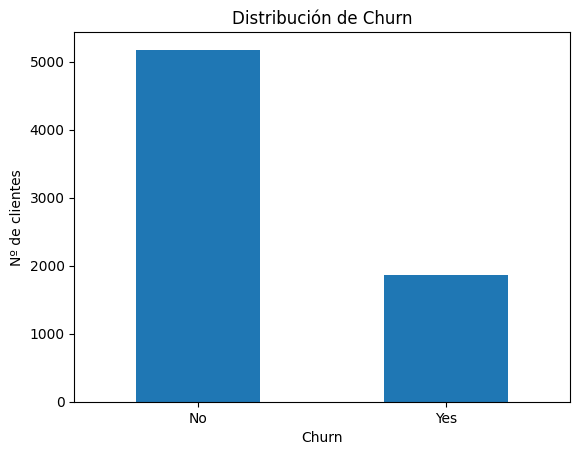

In [ ]:


churn_counts = df["Churn"].value_counts()
churn_rate = df["Churn"].mean()

print("Distribución de clases:")
display(churn_counts)
print(f"\nTasa de churn: {churn_rate:.2%}")

churn_counts.plot(kind="bar", title="Distribución de Churn", xlabel="Churn", ylabel="Nº de clientes")
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.show()

### Análisis de la variable objetivo: `Churn`

En esta sección se analiza la distribución de la variable objetivo `Churn`, que indica si un cliente ha abandonado el servicio:

- **Clase 0 (No churn)**: 5.174 clientes  
- **Clase 1 (Sí churn)**: 1.869 clientes  
- **Tasa de churn**: 26.55%

Este desequilibrio refleja un **problema de clases desbalanceadas**, que puede afectar negativamente el rendimiento de ciertos algoritmos de clasificación. Será importante tenerlo en cuenta más adelante al seleccionar métricas de evaluación o aplicar técnicas de balanceo como `SMOTE`, `undersampling`, o el uso de `class_weight`.

---

### Distribución de variables numéricas por clase (`Churn`)

Se utilizan diagramas de cajas (*boxplots*) para explorar cómo se comportan algunas variables numéricas clave en función de la clase de salida (`Churn`):

#### `tenure` (tiempo como cliente)
Clientes que **no abandonan** tienden a tener una mayor antigüedad. Los que **sí abandonan** se concentran en los primeros meses de contratación.

#### `MonthlyCharges` (facturación mensual)
Los clientes que **abandonan** tienden a tener facturas mensuales más altas. Esto podría sugerir una mayor sensibilidad al precio o una relación con los servicios contratados.



#### `TotalCharges` (facturación total acumulada)
Los clientes que han estado más tiempo (y no han abandonado) presentan valores de `TotalCharges` significativamente más altos, lo cual es esperable.






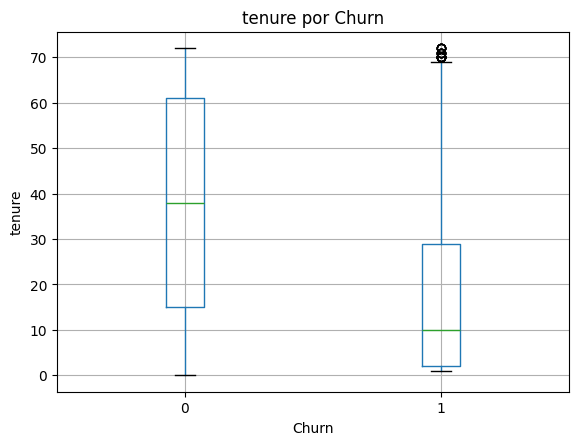

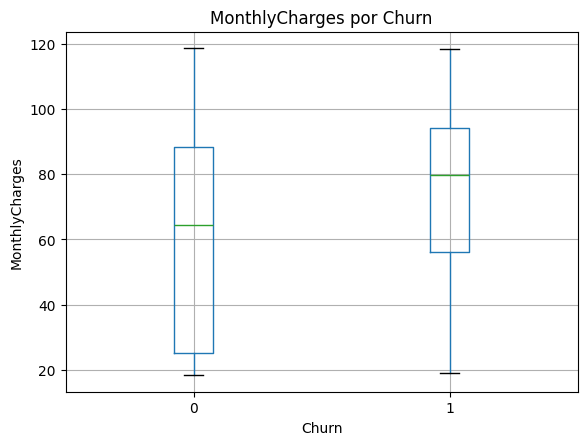

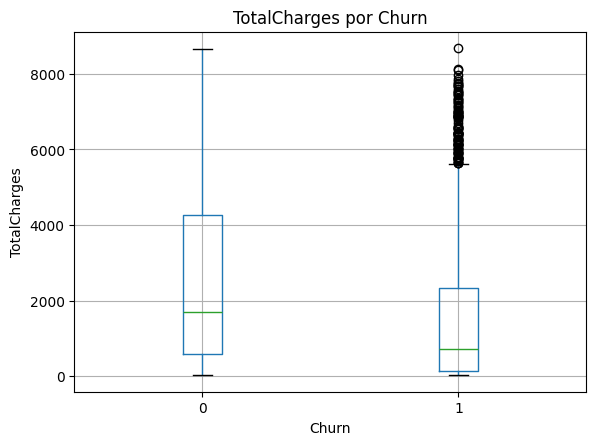

In [68]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in num_cols:
    if col in df.columns:
        df.boxplot(column=col, by="Churn")
        plt.title(f"{col} por Churn")
        plt.suptitle("")
        plt.ylabel(col)
        plt.show()


### Resumen estadístico de variables numéricas por clase (`Churn`)

Se muestra un resumen de las principales estadísticas descriptivas (`media`, `mediana`, `desviación estándar`, `mínimo` y `máximo`) para cada variable numérica, diferenciadas por clase (`Churn = 0` y `Churn = 1`):

| Variable         | Métrica | Churn = 0       | Churn = 1       | Observaciones destacadas |
|------------------|---------|------------------|------------------|----------------------------|
| **SeniorCitizen** | Media   | 0.129            | 0.255            | Hay una mayor proporción de personas mayores entre quienes abandonan. |
|                  | Mediana | 0.000            | 0.000            | La mayoría no son seniors, pero los que lo son abandonan más. |
| **tenure**        | Media   | 37.57            | 17.98            | Los clientes que se quedan tienen mucha más antigüedad. |
|                  | Mediana | 38.00            | 10.00            | Confirmación clara del patrón de abandono temprano. |
| **MonthlyCharges**| Media   | 61.27            | 74.44            | Los clientes que abandonan tienden a pagar más al mes. |
|                  | Mediana | 64.43            | 79.65            | El patrón se mantiene con la mediana. |
| **TotalCharges**  | Media   | 2555.34          | 1531.80          | Total acumulado más bajo en los clientes que se van, ligado al menor tiempo. |
|                  | Mediana | 1683.60          | 703.55           | Se refuerza el patrón de menor duración y facturación. |

Este análisis numérico respalda las observaciones gráficas previas: los clientes que abandonan tienden a tener menor permanencia (`tenure`) y menor gasto total (`TotalCharges`), pero su factura mensual (`MonthlyCharges`) es más alta. Además, ser `SeniorCitizen` parece estar correlacionado con una mayor tasa de abandono.


In [69]:
from src.telco_churn.eda import num_summary_by_target

num_summary_by_target(df)


Churn                            0            1
SeniorCitizen  mean       0.128721     0.254682
               median     0.000000     0.000000
               std        0.334923     0.435799
               min        0.000000     0.000000
               max        1.000000     1.000000
tenure         mean      37.569965    17.979133
               median    38.000000    10.000000
               std       24.113777    19.531123
               min        0.000000     1.000000
               max       72.000000    72.000000
MonthlyCharges mean      61.265124    74.441332
               median    64.425000    79.650000
               std       31.092648    24.666053
               min       18.250000    18.850000
               max      118.750000   118.350000
TotalCharges   mean    2555.344141  1531.796094
               median  1683.600000   703.550000
               std     2329.456984  1890.822994
               min       18.800000    18.850000
               max     8672.450000  8684.800000

### Matriz de correlación (variables numéricas)

Se calcula la correlación de Pearson entre las variables numéricas del conjunto (`tenure`, `MonthlyCharges`, `TotalCharges`) y se visualiza en un mapa de calor.

**Hallazgos principales:**
- `tenure` ↔ `TotalCharges` ≈ 0.83 (fuerte, positiva): el cargo total crece con el tiempo. En la práctica, `TotalCharges` ≈ `MonthlyCharges × tenure` ± recargos/bonificaciones, por lo que ambas variables comparten gran parte de la varianza.
- `MonthlyCharges` ↔ `TotalCharges` ≈ 0.65 (moderada, positiva): a mayor factura mensual, mayor acumulado; la relación no es perfecta porque también depende de `tenure`.
- `tenure` ↔ `MonthlyCharges` ≈ 0.25 (débil, positiva): el precio mensual depende del paquete/servicios contratados, no necesariamente de la antigüedad; clientes nuevos pueden tener tarifas altas o bajas según el bundle, por eso la asociación es baja.

**Patrones y razonamiento:**
- La fuerte asociación `tenure–TotalCharges` sugiere **multicolinealidad**: ambas variables codifican información temporal/acumulada muy similar. En modelos lineales (p. ej., regresión logística) puede inflar varianzas de coeficientes y dificultar la interpretación.
- `TotalCharges` se comporta como una **variable “casi derivada”** de `tenure` y `MonthlyCharges`. Por tanto, puede ser redundante o introducir ruido si existen ajustes puntuales (descuentos, cargos únicos) que rompen la proporcionalidad simple.
- `MonthlyCharges` refleja la **intensidad de servicios** (p. ej., fibra, streaming, líneas múltiples), mientras que `tenure` refleja **antigüedad**. Son dimensiones distintas; su baja correlación sugiere que ambos aportan señales complementarias: precio actual vs. madurez del cliente.
- Posibles **confusores de negocio**: el tipo de contrato (mes a mes vs. anual) o el tipo de internet (DSL vs. fibra) puede influir simultáneamente en `MonthlyCharges` y en la propensión a acumular `TotalCharges`, generando dependencias indirectas.

**Implicaciones para el modelado:**
- En modelos lineales, considerar:
  - eliminar una de las dos variables colineales (`TotalCharges` o `tenure`), o
  - usar regularización (L1/L2) y comprobar VIF para diagnosticar multicolinealidad.
- En modelos basados en árboles (Random Forest, Gradient Boosting), la colinealidad es menos problemática, pero sigue siendo aconsejable vigilar la estabilidad de importancias.
- Ingeniería de características recomendada:
  - `ExpectedTotal = MonthlyCharges × tenure` y `Ratio = TotalCharges / (ExpectedTotal + ε)` para capturar desviaciones respecto a lo esperado (p. ej., descuentos, cargos únicos, impagos).
  - Estandarizar numéricas si se emplean modelos sensibles a escala.

La figura de la matriz de correlación refleja estos patrones y magnitudes, y guía la selección/transformación de variables para una mejor generalización del modelo.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Javichu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


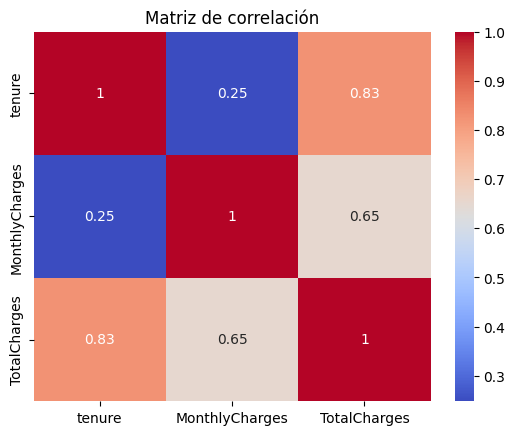

In [70]:
%pip install seaborn

import seaborn as sns

corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()


### Tasa de churn por variables categóricas

Se calcula la tasa de churn por categoría junto con el tamaño de cada grupo (`n`). Las variables mostradas son fuertes candidatas a predictores por su poder discriminativo.

#### Contract
- **Month-to-month**: 42.7% de churn (n=3,875)  
- **One year**: 11.3% (n=1,473)  
- **Two year**: 2.8% (n=1,695)  

**Lectura:** los contratos mensuales presentan una probabilidad de baja muy superior. Los compromisos a 1–2 años actúan como mecanismo de retención.

---

#### InternetService
- **Fiber optic**: 41.9% (n=3,096)  
- **DSL**: 19.0% (n=2,421)  
- **No**: 7.4% (n=1,526)

**Lectura:** el servicio de fibra se asocia con más churn, probablemente por mayores importes mensuales y expectativas de calidad; “No internet” suele corresponder a clientes solo de telefonía, con baja tasa de baja. Conviene analizar la interacción con `MonthlyCharges` y `Contract`.

---

#### PaymentMethod
- **Electronic check**: 45.3% (n=2,365)  
- **Mailed check**: 19.1% (n=1,612)  
- **Bank transfer (automatic)**: 16.7% (n=1,544)  
- **Credit card (automatic)**: 15.2% (n=1,522)

**Lectura:** los pagos automáticos (transferencia o tarjeta) se asocian a menor churn; el pago por “Electronic check” concentra la mayor tasa. Posible efecto de fricción de pago y perfil de cliente.

---

#### TechSupport
- **No**: 31.2% (n=4,999)  
- **Yes**: 15.2% (n=2,044)

**Lectura:** disponer de soporte técnico reduce aproximadamente a la mitad la probabilidad de baja. Puede ser proxy de adopción/engagement.

---

#### OnlineSecurity
- **No**: 31.3% (n=5,024)  
- **Yes**: 14.6% (n=2,019)

**Lectura:** poseer seguridad online también se asocia a menor churn; su efecto es similar al de `TechSupport`.

---

#### Implicaciones para modelado y negocio
- **Modelado:** estas variables deben incluirse y codificarse (one-hot). Considerar interacciones con `MonthlyCharges` y `tenure`. En modelos lineales, vigilar colinealidad; en árboles, menor impacto pero revisar importancias/SHAP.
- **Métricas:** por el desbalance, evaluar con ROC-AUC, F1 y curvas PR además de accuracy.
- **Acciones de negocio sugeridas:** fomentar migración de **Month-to-month** a contratos anuales, incentivar **pagos automáticos**, y bundles con **TechSupport** y **OnlineSecurity**, especialmente en clientes de **fibra** con cargos mensuales altos.



In [71]:
from src.telco_churn.eda import churn_rate_table

cat_cols = ["Contract", "InternetService", "PaymentMethod", "TechSupport", "OnlineSecurity"]

for col in cat_cols:
    print(f"\n==== {col} ====")
    display(churn_rate_table(df, col, top=10))



==== Contract ====


,rate,n
Contract,,
Month-to-month,0.427097,3875
One year,0.112695,1473
Two year,0.028319,1695



==== InternetService ====


,rate,n
InternetService,,
Fiber optic,0.418928,3096
DSL,0.189591,2421
No,0.074050,1526



==== PaymentMethod ====


,rate,n
PaymentMethod,,
Electronic check,0.452854,2365
Mailed check,0.191067,1612
Bank transfer (automatic),0.167098,1544
Credit card (automatic),0.152431,1522



==== TechSupport ====


,rate,n
TechSupport,,
No,0.311862,4999
Yes,0.151663,2044



==== OnlineSecurity ====


,rate,n
OnlineSecurity,,
No,0.313296,5024
Yes,0.146112,2019


Paso 8: Analisis de importacia de variables


In [ ]:


X = df.drop(columns=["Churn"])
y = df["Churn"]

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

X_enc = preprocessor.fit_transform(X)
feat_names = num_cols + list(preprocessor.named_transformers_["cat"]["ohe"].get_feature_names_out(cat_cols))

mi = mutual_info_classif(X_enc, y, random_state=42)
mi_df = pd.DataFrame({"feature": feat_names, "mutual_info": mi})
mi_df.sort_values("mutual_info", ascending=False).head(15)


,feature,mutual_info
29,Contract_Month-to-month,0.101677
1,tenure,0.063314
31,Contract_Two year,0.056425
2,MonthlyCharges,0.048263
36,PaymentMethod_Electronic check,0.043864
3,TotalCharges,0.043082
15,InternetService_Fiber optic,0.035833
16,InternetService_No,0.024882
17,OnlineSecurity_No,0.020798
30,Contract_One year,0.018710


### Ingeniería de variables: `ExpectedTotal` y `Ratio` y Prueba de Leakage

- Se crean:
  - `ExpectedTotal = MonthlyCharges * tenure`
  - `Ratio = TotalCharges / ExpectedTotal` (inf → NaN)

**`Ratio.describe()` (resumen):**
- media ≈ 1.000, std ≈ 0.051, IQR ~ [0.98, 1.02], mín ≈ 0.689, máx ≈ 1.573.  
- Cerca de 1 = facturación acorde a lo esperado; < 0.95 posibles descuentos; > 1.05 posibles recargos.

**Nota (warning pandas):** evita asignación encadenada:
```python
df["Ratio"] = df["TotalCharges"].div(df["ExpectedTotal"]).replace([np.inf, -np.inf], np.nan)


In [73]:
df["ExpectedTotal"] = df["MonthlyCharges"] * df["tenure"]
df["Ratio"] = df["TotalCharges"] / df["ExpectedTotal"]
df["Ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)

print("Relación TotalCharges / (MonthlyCharges * tenure):")
display(df["Ratio"].describe())


Relación TotalCharges / (MonthlyCharges * tenure):


C:\Users\Javichu\AppData\Local\Temp\ipykernel_21012\531357346.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)


count    7032.000000
mean        1.000275
std         0.051159
min         0.689356
25%         0.979546
50%         1.000000
75%         1.019562
max         1.573454
Name: Ratio, dtype: float64

## 📌 Conclusiones del Análisis Exploratorio de Datos (EDA)

### 🎯 Distribución de la variable objetivo (`Churn`)
- El dataset está moderadamente desbalanceado:
  - Aproximadamente **26-27%** de los clientes hacen churn.
  - Es importante tener esto en cuenta en el entrenamiento (stratify, class_weight, etc.).

---

### 📊 Variables categóricas con relación al churn

- **Contract**:
  - Clientes con contrato **"Month-to-month"** tienen la **tasa de churn más alta** (~43%).
  - Contratos anuales o bianuales retienen mucho mejor a los clientes.

- **InternetService**:
  - Los clientes con **"Fiber optic"** presentan más churn (~42%) frente a los de DSL (~19%) o sin servicio.

- **TechSupport** y **OnlineSecurity**:
  - La ausencia de estos servicios está **fuertemente asociada al churn**.
  - Tener soporte o seguridad reduce la tasa de abandono.

- **PaymentMethod**:
  - **Electronic check** se asocia a más churn (~34%).
  - Métodos automáticos (como tarjeta o transferencia) presentan menor churn (~15%).

---

### 🔢 Variables numéricas asociadas al churn

- **Tenure (antigüedad)**:
  - La variable con **mayor poder predictivo negativo**: más antigüedad → menor churn.

- **MonthlyCharges**:
  - Los clientes que pagan más tienden a hacer más churn, posiblemente por tener más servicios activos.

- **TotalCharges**:
  - Relacionada con `tenure`, también inversamente proporcional al churn.
  - Se detectó que puede inducir *leakage*, ya que se deriva de `tenure × MonthlyCharges`.

---

### ✅ Calidad de datos

- **TotalCharges** contenía valores no numéricos (limpiados con `pd.to_numeric(..., errors="coerce")`).
- No hay columnas con nulos significativos (>5%).
- Se unificaron categorías como `"No internet service"` → `"No"`.

---

### 🧠 Observaciones adicionales

- Algunas variables categóricas tienen muchas categorías (`PaymentMethod`, `InternetService`), requerirán One-Hot Encoding.
- Variables como `TotalCharges` son redundantes y podrían descartarse para evitar *data leakage*.
- Hay correlaciones claras que se deben considerar si se usan modelos lineales.

---

### ✅ Conclusión general

- Ya se identificaron varias variables relevantes para modelado.
- El análisis sugiere que `Contract`, `tenure`, y servicios como `TechSupport` son claves para predecir churn.
- El dataset es suficientemente limpio y balanceado como para construir un modelo baseline.



## Baseline + Entrenamiento + Evaluación


### Construir Pre-procesador de datos


In [19]:
from src.telco_churn.features import build_preprocessor

X = df.drop(columns=["Churn"])
y = df["Churn"]

preprocessor = build_preprocessor(X)
X_prepared = preprocessor.fit_transform(X)
X_prepared.shape


(7043, 40)

### Baseline de clasificación con Regresión Logística

Este bloque entrena y evalúa un modelo baseline usando una **Regresión Logística** dentro de un **Pipeline** que incluye el preprocesamiento.

**Pasos principales**
- **Definición de variables**: `X = df` sin `Churn`; `y = df["Churn"]`.
- **Preprocesado** (`build_preprocessor(X)`): imputación de nulos, escalado de numéricas y codificación One-Hot de categóricas.
- **Partición estratificada**: `train_test_split` con `test_size=0.2`, manteniendo la proporción de clases.
- **Modelo**: `LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)` para mitigar el desbalance.
- **Entrenamiento**: `clf.fit(X_train, y_train)`.

**Evaluación**
- **Classification report**: precisión, recall y F1 por clase, además de macro/weighted averages.
- **ROC AUC**: métrica agregada basada en `y_prob = predict_proba(...)`.
- **Matriz de confusión**: visualización con `seaborn.heatmap` para aciertos/errores por clase.

**Notas**
- `class_weight="balanced"` ayuda a compensar el desbalance de `Churn`.
- Con `y_prob` se puede ajustar el **umbral de decisión** según el coste de falsos positivos/negativos.
- Este baseline sirve de referencia para comparar con modelos más complejos (p. ej., Random Forest, Gradient Boosting).


✅ Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC AUC Score: 0.841840398873647


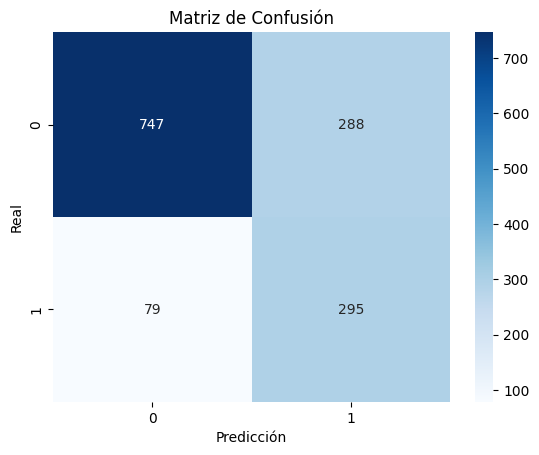

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 🧪 Features y target
X = df.drop(columns=["Churn"])
y = df["Churn"]

# 🧹 Preprocesador
from src.telco_churn.features import build_preprocessor
preprocessor = build_preprocessor(X)

# 🔀 Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 🧠 Modelo baseline
clf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

clf.fit(X_train, y_train)

# 📊 Evaluación
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("✅ Classification Report:\n")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


### Entrenamiento y tracking con MLflow (RandomForest)

Este bloque entrena un **RandomForestClassifier** mediante la función utilitaria `train_and_log_model`, dejando trazas completas en **MLflow**.

**Qué hace `train_and_log_model`:**
- Separa `X = df` sin `Churn` y `y = df["Churn"]`.
- Split estratificado en train/test.
- Construye el **preprocesador** con `build_preprocessor(X)` y lo encadena en un `Pipeline` con el modelo.
- Entrena el modelo y calcula métricas de evaluación:
  - `roc_auc` y, del `classification_report`, `precision`, `recall` y `f1-score` (ponderadas).
- Registra en MLflow:
  - **Parámetros** del modelo (`n_estimators`, `class_weight`, etc.).
  - **Métricas**.
  - **Artefactos**: el modelo serializado bajo `artifacts/model/`.

**Configuración usada:**
- Experimento: `telco_churn_experiment`.
- Modelo: `RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)`.
- Nombre de la ejecución (run): `RandomForest_baseline`.

**Cómo visualizar resultados:**
- Lanza la UI de MLflow: `mlflow ui --port 5000`
- Abre `http://127.0.0.1:5000`, entra en `telco_churn_experiment` y revisa:
  - Métricas comparables entre runs.
  - Parámetros y artefactos (modelo listo para servir).



In [23]:
from sklearn.ensemble import RandomForestClassifier
from src.telco_churn.train import train_and_log_model


rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42
)

train_and_log_model(
    df=df,  # Incluye la columna 'Churn'
    model=rf_model,
    model_name="RandomForest_baseline",
    experiment_name="telco_churn_experiment",
    
)



✅ Modelo 'RandomForest_baseline' entrenado y loggeado con MLflow.


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [26]:
import mlflow

experiment = mlflow.get_experiment_by_name("telco_churn_experiment")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
print(runs[["run_id", "metrics.roc_auc"]])



                             run_id  metrics.roc_auc
0  de2e390183be4ca1825f70c0175296c1         0.827694
1  983dffa054f34baead585bed11bb989e         0.827694
2  e1f603ba9a534dc59036991ebc7f35b8         0.827694
3  0fa067c4946048c4930fceea0d5f5dfc         0.827694
4  55b02a97b5e84292ac83d0aace37e917         0.827694
5  4269d628daae4a32b41ba49c2c00287e         0.827694
6  c33900e9731e48a99bb4cb9d527eaf06         0.827694


Input de prueba al modelo


In [55]:
!python "C:/Users/Javichu/OneDrive - UFV/Escritorio/personal/Capgemini/Capgemini/src/telco_churn/predict_local.py"



A) dataframe_records -> 200
Pred: {'predictions': [0]}
